# doubleIntegratorPyomo.ipynb
This Jupyter notebook provides a brief introduction to Pyomo using a double integrator as an illustrative example.


Author: Angelo D. Bonzanini
(c) 2021

## Why Use Pyomo?
<p></p>

* Intiutive/easy-to-use $\rightarrow$ can formulate large models with concise syntax.
* Integrated automatic differentiation.
* Easy integration with commercial and open-source solvers, as well as the NEOS server.
* Model transformations
    * E.g., Generalized disjunctive programming allows users to include logical disjunctions in their models. Automatically converts a model with logical constraints to a MI(N)LP.


## Disclaimer
<p>&nbsp;</p>

I have not taken a class on how to use Pyomo. The information that I present below is just some useful things I had to learn by googling. Hopefully it will save you some time in the future.
<p>&nbsp;</p>

Furthremore, there is no single right or wrong way to code things. This is just my personal preference. Please let me know if you have any feedback on how to further streamline things.
<p>&nbsp;</p>


Also, I am assuming that the audience (like me) has had only limited "formal" experience with coding.

## Installing Pyomo
<p>&nbsp;</p>

Linux and MacOS typically have Python already installed.
<p>&nbsp;</p>

Installing pyomo can be as easy as typing ```pip install pyomo``` in the terminal window. Alternatively, you can type ```!pip install pyomo``` within the Jupyter notebook environment. 
<p>&nbsp;</p>

Pyomo does NOT come with solvers pre-installed, so you will need to install those separately. Different solvers are available through anaconda, macports, or homebrew. 
* In my opinion, homebrew is the easiest to use. Installation of a solver can be as easy as typing ```brew install ipopt``` in the terminal window. The only issue is that not all solvers are available on homebrew. See https://brew.sh/ for details.
* Many other open source solvers are available through Coin-OR (https://www.coin-or.org/#ffs-tabbed-11), though installation is more-tricky.
* Pyomo can also interface with the NEOS server (https://neos-server.org/neos/), which is an internet-based service for solving optimization problems. In order to use NEOS you need to register for a free account and then include your email through the command in the imports section.
* This is the stage where you typically have to do some googling related to the specific solver you are trying to use.

## Imports

In [14]:
import os.path
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import shutil
from pyomo.environ import *
from pyomo.dae import *
from pyomo.gdp import *

os.environ['NEOS_EMAIL'] = 'adbonzanini@berkeley.edu'

%matplotlib notebook

## Define classes
At this point, I like to organize my code in classes, which are like "blueprints" for creating objects. Objects, in turn, are a collection of data as well as methods/functions that act on those data.
<p>&nbsp;</p>

Once I have the classes defined, I can easily implement an MPC with different initial conditions or parameters, just by defining (instantiating) a new object using the same class. 
<p>&nbsp;</p>

Classes also let me keep my code tidy and easier to read, though at the end of the day that is just my personal preference.

### Toy example
If you are completely unfamiliar with classes (like I was before taking a short course on C++), here is an example on why classes can be useful.
<p>&nbsp;</p>

For example, let's try to keep track of two dogs that I wish I had, Gatsby and Daisy

In [15]:
# Conventionally, classes are defined with a capital first letter
class Dog:
    # First thing I do is to intialize the "class variables". These are variables that are
    # shared by all instance of the class
    kind = 'canine'
    nLegs = 4
    
    # Instance variables, on the other hand, are unique to each instance of the class
    # and will be defined when we "instantiate" the class below
    def __init__(self, name, age, boyOrGirl):  # Note that the first argument of any method is the keyword "self"
        self.name = name
        self.age = age
        self.gender = boyOrGirl
        
    # Next, define the methods (functions) that are relevant to the class
    def speak(self):
        print("Woof")
        return
        
    def goodPet(self):
        print("Good ", self.gender,"!")


Now, it's time to create the objects for different dogs

In [16]:
dog1 = Dog("Gatsby", 5, "boy")
dog2 = Dog("Daisy", 2, "girl")

Let's print out their data

In [17]:
print(dog1.kind, dog1.name, dog1.age)
print(dog2.kind, dog2.name, dog2.age)

canine Gatsby 5
canine Daisy 2


And now let's call some functions

In [18]:
dog1.goodPet()
dog1.speak()
print("\n")
dog2.goodPet()
dog2.speak()

Good  boy !
Woof


Good  girl !
Woof


### Example relevant to our double integrator problem

Our plant dynamics are given by
\begin{align}
x_{k+1} = Ax_k + Bu_k + w_k,
\end{align}
where $A = \begin{bmatrix}1 & 1 \\ 0  & 1 \end{bmatrix}$, $B = \begin{bmatrix}0.5 \\ 1\end{bmatrix}$, and $w \sim \mathcal{N}\left(0, \Sigma^w\right)$.

At each sampling time we are trying to solve the following optimal control problem

\begin{align}
V_N^*(x_k) =& \sum_{j=0}^{N-1} \left\{ 
\left(x_{j|k}-x^{\text{sp}}\right)^\top Q \left(x_{j|k}-x^{\text{sp}}\right) 
+ \left(u_{j|k}-u^{\text{sp}}\right)^\top R \left(u_{j|k}-u^{\text{sp}}\right) 
\right\}
\\
&\hspace{9cm} + \left(x_{N|k}-x^{\text{sp}}\right)^\top P_N \left(x_{N|k}-x^{\text{sp}}\right) 
\\
\text{s.t. } & x_{j+1|k} = Ax_{j|k} + Bu_{j|k}
\\
& x \in \left[-10, 10 \right]^2
\\
& u \in \left[-5, 5 \right]
\\
& x_{0|k} = x_k
\end{align}

In [19]:
# Parameters
class Parameters:
    # Dynamics
    A = np.array([[1, 1], [0, 1]])
    B = np.array([0.5, 1]).reshape(-1,1)
    
    # Horizon lengths
    Np =  5     # Prediction horizon
    Nsim = 20    # Simulation horizon
    
    # Dimensions
    nx = A.shape[1]
    nu = B.shape[1]
    
    # Constraints
    x_min = [-10]*nx
    x_max = [10]*nx
    u_min = [-5]*nu
    u_max = [5]*nu
    
    # Cost function parameters
    Q = np.array([[1, 0], [0, 1]])
    R = 0.1*np.eye(nu, nu)
    PN = 2*Q
    xSP = [0, 0]
    uSP = [0]
    
    # Initial conditions
    xInit = [3, -2]
    
    # Uncertainty realizations
    np.random.seed(0)
    noiseSequence = 0*np.random.normal(0, 0.1, size = (nx,Nsim+1))

# Create a class to store the solution of the MPC later on
class Solution:
    pass

In [20]:
# Instantiate objects
p = Parameters()
sln = Solution()

# Print some parameters to test
print("nx = ", p.nx)
print("nu = ", p.nu)
print("Q = ", p.Q)
print("R = ", p.R)

nx =  2
nu =  1
Q =  [[1 0]
 [0 1]]
R =  [[0.1]]


In [21]:
class MPC():   
    # Method that builds the optimal control problem
    def ocpBuild(p):
        # Define a concrete optimization model that does *not* defer construction of components.
        m = ConcreteModel()
        
        # Define prediction index k and variable sizes as RangeSets (discrete sets)
        m.k = RangeSet(0, p.Np)
        m.nx = RangeSet(0, p.nx-1)
        m.nu = RangeSet(0, p.nu-1)

        # States and inputs
        m.x = Var(m.nx, m.k) 
        m.u = Var(m.nu, m.k)
        
        # Initial condition
        for i in m.nx:
            m.x[i,0].fix(p.xInit[i])
        
        # Limits on the states and inputs
        m.constraints = ConstraintList()
        for j in m.k:
            for i in m.nx:
                m.constraints.add(inequality(p.x_min[i], m.x[i,j], p.x_max[i]))
            for i in m.nu:
                m.constraints.add(inequality(p.u_min[i], m.u[i,j], p.u_max[i]))

        # Dynamics    
        m.dynamics1 = Constraint(m.k, rule = lambda m, k: m.x[0, k+1] == float(p.A[0,0])*m.x[0,k] + float(p.A[0,1])*m.x[1,k] + float(p.B[0])*m.u[0,k] if k < p.Np else Constraint.Skip)
        m.dynamics2 = Constraint(m.k, rule = lambda m, k: m.x[1, k+1] == float(p.A[1,0])*m.x[0,k] + float(p.A[1,1])*m.x[1,k] + float(p.B[1])*m.u[0,k] if k < p.Np else Constraint.Skip)
        
        # Objective function
        m.totalCost = sum(p.Q[0,0]*(m.x[0,k]-p.xSP[0])**2 + p.Q[1,1]*(m.x[1,k]-p.xSP[1])**2 + p.R[0,0]*(m.u[0,k]-p.uSP[0])**2  for k in m.k)
        m.obj = Objective(expr=m.totalCost, sense=minimize)
        
        return m
    
    # Method that solves the optimal control problem
    def ocpSolve(m):
#         TransformationFactory('gdp.bigm').apply_to(m)
#         solOut = SolverFactory('gdpopt').solve(m, mip_solver='glpk')
#         solOut = SolverManagerFactory('neos').solve(m, opt='couenne', tee=True)
        solOut = SolverFactory('ipopt').solve(m)
        if str(solOut.solver.termination_condition) != "optimal":
            print('-------------------------------------')
            print(solOut.solver.termination_condition)
            print('-------------------------------------')

        # Save solution in an object
        sln.tPred = [m.k for k in m.k]
        sln.x1Pred = [m.x[0, k]() for k in m.k]
        sln.x2Pred = [m.x[1, k]() for k in m.k]
        sln.uPred = [m.u[0,k]() for k in m.k]

        return sln  

#### Define a function that solves the OCP in a loop and a function that takes its output and plots the figures

In [28]:
def mpcSolve(m, p):
    x0 = p.xInit
    xSim = np.zeros((p.nx, p.Nsim+1))
    xSim[:,0] = x0
    uSim = np.zeros((p.nu, p.Nsim))

    for k in range(0, p.Nsim):
        # Update initial conditions
        m.x[0,0].fix(x0[0])
        m.x[1,0].fix(x0[1])
        # Solve the OCP
        sln = mpc.ocpSolve(m)
        # Extract first optimal input
        uMPC = sln.uPred[0]

        # Update initial condition
        x0 = np.matmul(p.A, np.array(x0).reshape(-1,)) + np.matmul(p.B, np.array(uMPC).reshape(-1,)) + p.noiseSequence[:,k]

        # Store trajectories
        uSim[:,k] = uMPC
        xSim[:,k+1] = x0
        
    return xSim, uSim


def plotFigures(x, u, p):
    plt.figure()
    # Subplot
    plt.subplot(311)
    plt.plot(x[0,:])
    plt.plot([0, p.Nsim], [p.xSP[0], p.xSP[0]], 'k--')
    plt.ylabel('$x_1$')
    # Subplot
    plt.subplot(312)
    plt.plot(x[1,:])
    plt.plot([0, p.Nsim], [p.xSP[1], p.xSP[1]], 'k--')
    plt.ylabel('$x_2$')
    # Subplot
    plt.subplot(313)
    plt.plot(u[0,:])
    plt
    plt.ylabel('$u$')
    plt.plot([0, p.Nsim-1], [p.uSP[0], p.uSP[0]], 'k--')
    plt.xlabel('Discrete Time')
    plt.show()

#### Formulate the optimal control problem (OCP)

In [29]:
# Create mpc object
mpc = MPC

# Formulate the optimal control problem
m = mpc.ocpBuild(p)

# Use the pprint() method to debug -- shows the problem in intuitive form
# m.pprint()

#### You can see which solvers are available locally and on the NEOS server by running the following

In [30]:
# !pyomo help --solvers

### Regulation to the origin

<IPython.core.display.Javascript object>


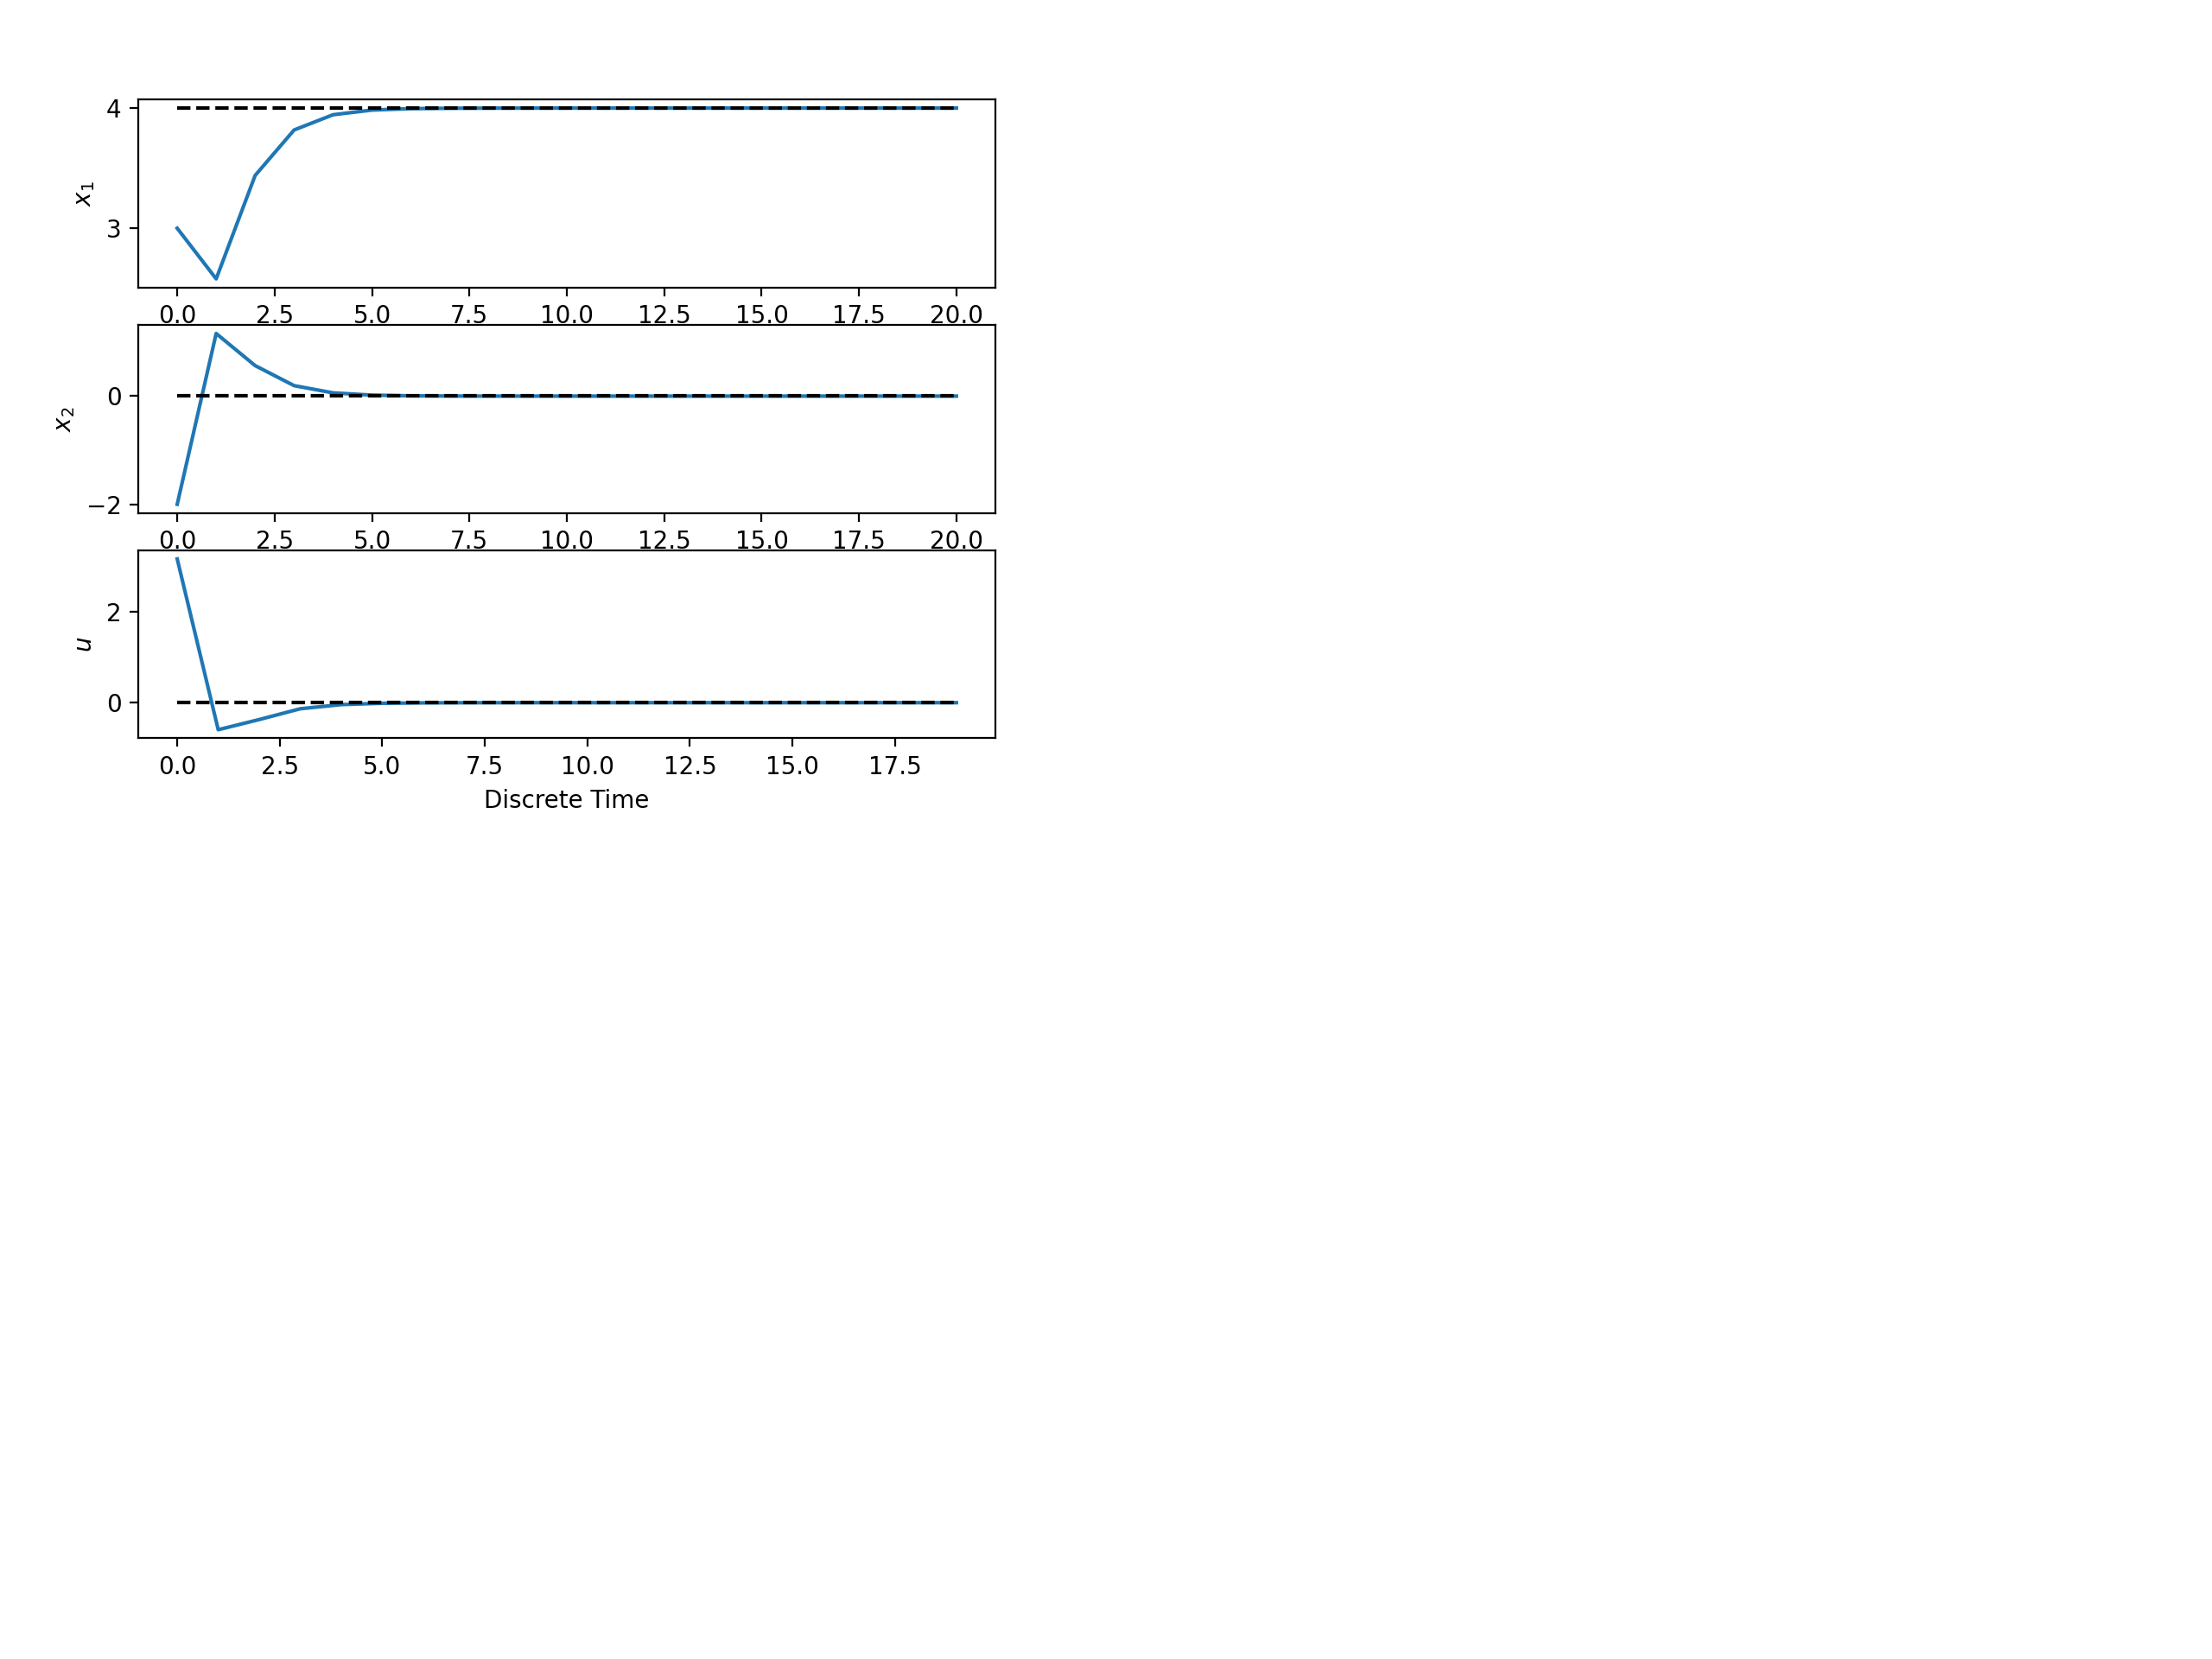

In [31]:
# Solve the MPC
xSim, uSim = mpcSolve(m, p)
# Plot the results
plotFigures(xSim, uSim, p)

### Setpoint Tracking

<IPython.core.display.Javascript object>


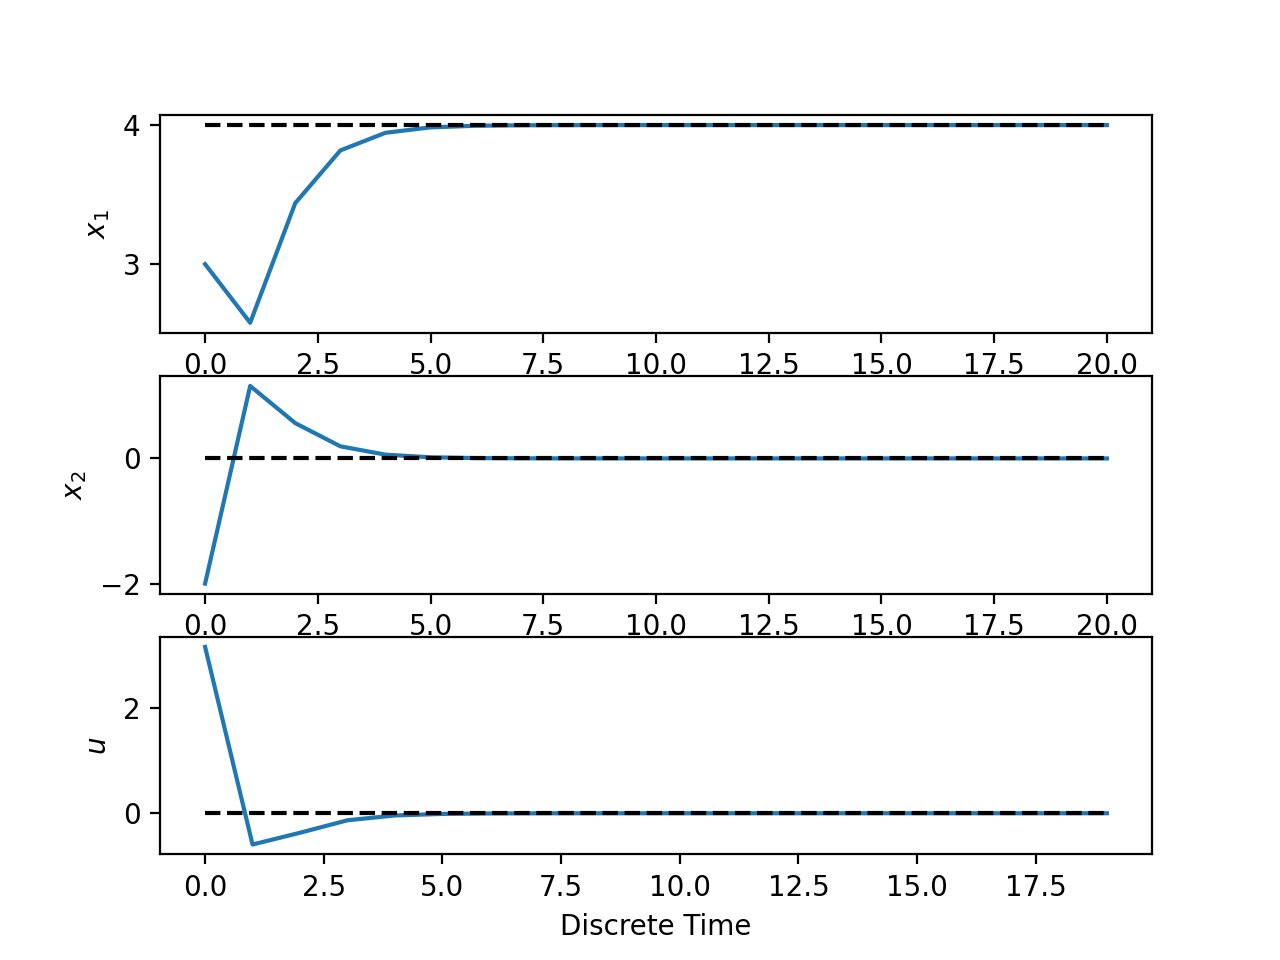

In [32]:
# Define setpoint for the states or outputs
p.xSP = [4, 0]

mpc = MPC
# Formulate the new OCP
m = mpc.ocpBuild(p)
# m.pprint()
# Solve the MPC
xSim, uSim = mpcSolve(m, p)
# Plot the results
plotFigures(xSim, uSim, p)